# __Selección del modelo__

## Cargar los datos

In [104]:
import os
import sys
import time 
import numpy as np

from joblib import dump
from datasets import load_dataset, DatasetDict
from transformers import AutoModel, AutoTokenizer, AutoConfig
from transformers import TrainingArguments, Trainer
from transformers.modeling_outputs import TokenClassifierOutput
from transformers import DataCollatorWithPadding, BertForSequenceClassification
from transformers import get_scheduler
from tqdm.auto import tqdm

from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.dummy import DummyClassifier

from torch import nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
import torch
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [1]:
data_files = { 'train': 'clean-data/train_clean.csv', 
               'val': 'clean-data/val_clean.csv',
               'test': 'clean-data/test_clean.csv' }

dataset_ES = load_dataset('csv', data_files=data_files)

In [2]:
dataset_ES

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 3660
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 549
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1098
    })
})

<!-- ## Modelos de Lenguaje  -->

## BERT with naive aproach 

Utilizamos la estrategia Feature straction model. 

El modelo de clasificación seleccionado fue BETO: Spanish BERT [link](https://huggingface.co/dccuchile/bert-base-spanish-wwm-uncased).

In [ ]:
# torch.__version__ #'2.4.1'

# os.environ.pop("TRANSFORMERS_CACHE", None)
# # Reset caché
# cache = ["TRANSFORMERS_CACHE", "HF_HOME", "HF_HUB_CACHE", "HF_ASSETS_CACHE"]
# for var in cache: 
#     os.environ.pop(var, None)

In [9]:
cache_path = os.path.abspath("./hf_cache")
model_name = "dccuchile/bert-base-spanish-wwm-uncased"
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    cache_dir=cache_path,
    local_files_only=False, # Forzamos que verifique online si el local falla
    force_download=True     # Solo la primera vez para reparar archivos
)

print(f"Tamaño del vocabulario {tokenizer.vocab_size}\n"
      f"model max_length {tokenizer.model_max_length}\n"
      f"Input names: {tokenizer.model_input_names}")

tokenizer_config.json:   0%|          | 0.00/310 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/310 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/310 [00:00<?, ?B/s]

Tamaño del vocabulario 31002
model max_length 512
Input names: ['input_ids', 'token_type_ids', 'attention_mask']


tokenize by batch 

In [10]:
def tokenize(batch):
  return tokenizer(batch["text"], padding=True, truncation=True)

In [11]:
dataset_encoded = dataset_ES.map(tokenize, batched=True, batch_size=True)

Map:   0%|          | 0/549 [00:00<?, ? examples/s]

In [12]:
dataset_encoded['train'].column_names

['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask']

In [14]:
model = AutoModel.from_pretrained(model_name).to(device)

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
text = "esta es una prueba"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


In [16]:
def extract_hidden_states(batch):
  inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}

  # Extract last hidden states 
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state

  # Return vector for [CLS] token
  return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [17]:
dataset_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
exist_hidden = dataset_encoded.map(extract_hidden_states, batched=True, batch_size=True)

Map:   0%|          | 0/3660 [00:00<?, ? examples/s]

Map:   0%|          | 0/549 [00:00<?, ? examples/s]

Map:   0%|          | 0/1098 [00:00<?, ? examples/s]

In [ ]:
# Hacemos un split de train/val/test
X_train = np.array(exist_hidden["train"]["hidden_state"])
X_valid = np.array(exist_hidden["val"]["hidden_state"])
y_train = np.array(exist_hidden["train"]["label"])
y_valid = np.array(exist_hidden["val"]["label"])

X_train.shape, X_valid.shape

((3660, 768), (549, 768))

Utilizamos la funcion ``score`` regresa el acurracy. 

In [19]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.7249544626593807

In [20]:
from sklearn.metrics import f1_score

y_pred = lr_clf.predict(X_valid)

f1 = f1_score(y_valid, y_pred, average='weighted')
print(f"F1-score: {f1:.4f}")

F1-score: 0.7149


### Dummy model

In [ ]:
f1_scores = []
strategies = ["stratified", "prior", "most_frequent"]

best_avg = -1.0
best_strategy = None

for strategy in strategies:
    scores = []
    for i in range(10):
        clf = DummyClassifier(strategy=strategy, random_state=i)
        clf.fit(X_train, y_train)
        f1_i = f1_score(y_valid, clf.predict(X_valid), average='weighted')
        scores.append(f1_i)
    f1d_avr = float(np.mean(scores))
    print("*" * 10)
    print(f"F1-score Dummy average by {strategy} (f1d_avr): {f1d_avr:.4f}")
    if f1d_avr > best_avg:
        best_avg = f1d_avr
        best_strategy = strategy

**********
F1-score Dummy average by stratified (f1d_avr): 0.5606
**********
F1-score Dummy average by prior (f1d_avr): 0.5450
**********
F1-score Dummy average by most_frequent (f1d_avr): 0.5450


In [53]:
# Retrain best strategy on full training set and save model
dummy_clf = DummyClassifier(strategy=best_strategy)
dummy_clf.fit(X_train, y_train)
# dump(best_clf, f"best_dummy_{best_strategy}.joblib")
# print(f"Saved best dummy model: best_dummy_{best_strategy}.joblib (avg f1={best_avg:.4f})")

DummyClassifier(strategy='stratified')

### Matrices de confusión

In [ ]:
import matplotlib.pyplot as plt

labels = list(set(dataset_ES["train"]['label']))  
label_map = {0: "Sexista", 1: "No sexista"}
display_labels = [label_map[l] for l in sorted(labels)]

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues_r",values_format=".3f",ax=ax,colorbar=True)
    ax.set_title("Matriz de confusión normalizada", fontsize=14, pad=12)
    ax.set(xlabel=None, ylabel=None)
    ax.tick_params(axis='both', labelsize=10)
    plt.show()



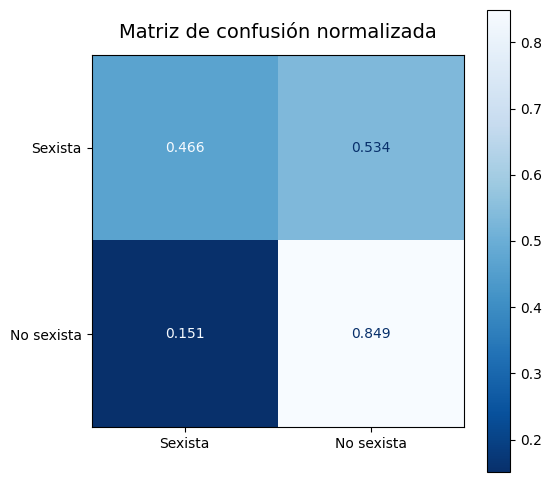

In [45]:
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, display_labels)

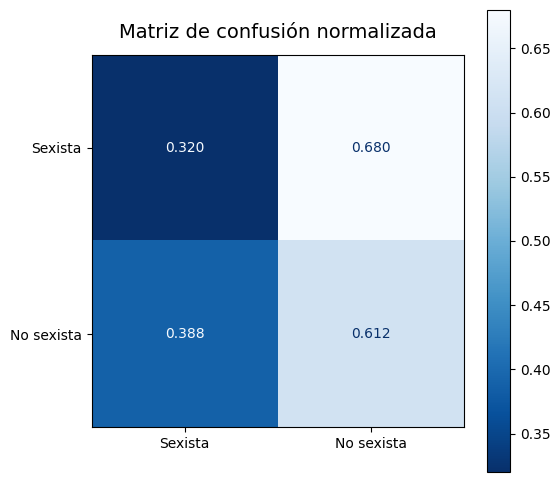

In [ ]:
# Para el dummy
y_preds = dummy_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, display_labels)

## BERT Fine Tunning

In [ ]:

# Desactivar explícitamente libuv y cualquier backend distribuido
os.environ["USE_LIBUV"] = "0"
os.environ["TORCH_DISTRIBUTED_DEBUG"] = "OFF"
os.environ["ACCELERATE_USE_CPU"] = "FALSE"

# Forzar configuración de un solo proceso
os.environ["WORLD_SIZE"] = "1"
os.environ["RANK"] = "0"
os.environ["LOCAL_RANK"] = "-1"
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "12345"

# Parche
try:
    from torch.distributed.tensor import DTensor
except ImportError:
    class MockDTensor:
        pass
    sys.modules["torch.distributed.tensor"] = MockDTensor
    print("✅ Parche de DTensor y libuv aplicado.")

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_id = "dccuchile/bert-base-spanish-wwm-uncased"

tokenizer = AutoTokenizer.from_pretrained(
    model_id, 
    cache_dir="./hf_cache",
    force_download=False # Cambia a True solo si el error de 'NoneType' persiste
)
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2).to(device)

c:\Users\ericl\anaconda3\envs\nlp\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


metrica de evaluación 

In [66]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [67]:
batch_size = 64
logging_steps = len(dataset_encoded["train"]) // batch_size
model_tag = f"{model_name}-finetuned-exist"

In [68]:
training_args = TrainingArguments(
    output_dir="./pruebas/PruebasExist/dccuchile",
    num_train_epochs=5,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    
    # CONFIGURACIÓN ANTIBUGS WINDOWS:
    dataloader_num_workers=0,    # 0 evita hilos secundarios que disparan errores de red
    fp16=True,                   # Usa esto si tienes GPU NVIDIA (ayuda mucho en Windows)
    local_rank=-1,               # FUERZA a ignorar grupos de procesos distribuidos
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_encoded['train'],
    eval_dataset=dataset_encoded['val'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

c:\Users\ericl\anaconda3\envs\nlp\Lib\site-packages\accelerate\accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


  0%|          | 0/290 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.4595715403556824, 'eval_accuracy': 0.7449908925318761, 'eval_f1': 0.7301377304828557, 'eval_runtime': 0.5658, 'eval_samples_per_second': 970.294, 'eval_steps_per_second': 15.906, 'epoch': 1.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.5066105723381042, 'eval_accuracy': 0.7632058287795993, 'eval_f1': 0.7350068281192235, 'eval_runtime': 0.5291, 'eval_samples_per_second': 1037.527, 'eval_steps_per_second': 17.009, 'epoch': 2.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.466585248708725, 'eval_accuracy': 0.7723132969034608, 'eval_f1': 0.7655297657671621, 'eval_runtime': 0.5837, 'eval_samples_per_second': 940.526, 'eval_steps_per_second': 15.418, 'epoch': 3.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.5025418996810913, 'eval_accuracy': 0.7650273224043715, 'eval_f1': 0.7585325457172423, 'eval_runtime': 0.5592, 'eval_samples_per_second': 981.734, 'eval_steps_per_second': 16.094, 'epoch': 4.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.5466837882995605, 'eval_accuracy': 0.7686703096539163, 'eval_f1': 0.7602160871766612, 'eval_runtime': 0.4341, 'eval_samples_per_second': 1264.659, 'eval_steps_per_second': 20.732, 'epoch': 5.0}
{'train_runtime': 82.9413, 'train_samples_per_second': 220.638, 'train_steps_per_second': 3.496, 'train_loss': 0.31377237254175644, 'epoch': 5.0}


TrainOutput(global_step=290, training_loss=0.31377237254175644, metrics={'train_runtime': 82.9413, 'train_samples_per_second': 220.638, 'train_steps_per_second': 3.496, 'total_flos': 489189229678080.0, 'train_loss': 0.31377237254175644, 'epoch': 5.0})

In [65]:
# from transformers import Trainer, TrainingArguments, EvalPrediction

# output_dir = "./results_bert_exist" 

# training_args = TrainingArguments(
#     output_dir=output_dir,
#     num_train_epochs=5,
#     learning_rate=2e-5,
#     per_device_train_batch_size=batch_size,
#     per_device_eval_batch_size=batch_size,
#     weight_decay=0.01,
#     eval_strategy="epoch", 
#     save_strategy="epoch",           # Guarda un checkpoint cada época por seguridad
#     load_best_model_at_end=True,     # Al finalizar, carga el mejor modelo según la métrica
#     metric_for_best_model="f1",      # Cambia "f1" por la métrica que uses en compute_metrics
#     save_total_limit=2,              # Evita llenar el disco (solo guarda los 2 mejores)
#     disable_tqdm=False,
#     logging_steps=logging_steps,
#     log_level="error",
#     report_to="none",
#     # Solución específica para Windows: evita errores de archivos bloqueados
#     dataloader_num_workers=0         
# )

# trainer = Trainer(
#     model=model, 
#     args=training_args,
#     compute_metrics=compute_metrics,
#     train_dataset=dataset_encoded['train'],
#     eval_dataset=dataset_encoded['val'],
#     tokenizer=tokenizer
# )

# # Ejecutar entrenamiento
# trainer.train()

# # 2. LA CLAVE: Guardado manual post-entrenamiento
# # Esto asegura que el vocabulario y la configuración del tokenizador 
# # se guarden correctamente en la carpeta final.
# trainer.save_model(output_dir) 
# tokenizer.save_pretrained(output_dir)

In [69]:
preds_output = trainer.predict(dataset_encoded["val"])

  0%|          | 0/9 [00:00<?, ?it/s]

In [70]:
preds_output.metrics

{'test_loss': 0.4595715403556824,
 'test_accuracy': 0.7449908925318761,
 'test_f1': 0.7301377304828557,
 'test_runtime': 0.358,
 'test_samples_per_second': 1533.676,
 'test_steps_per_second': 25.142}

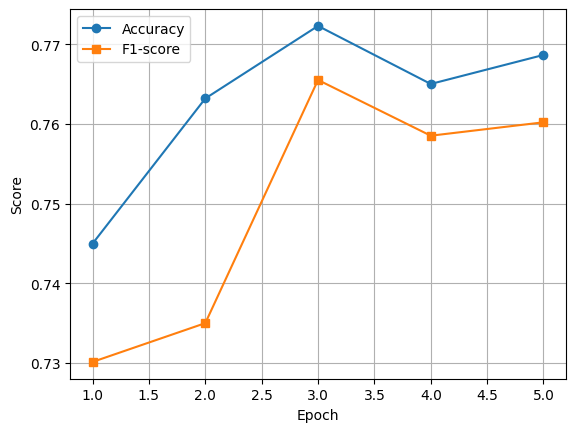

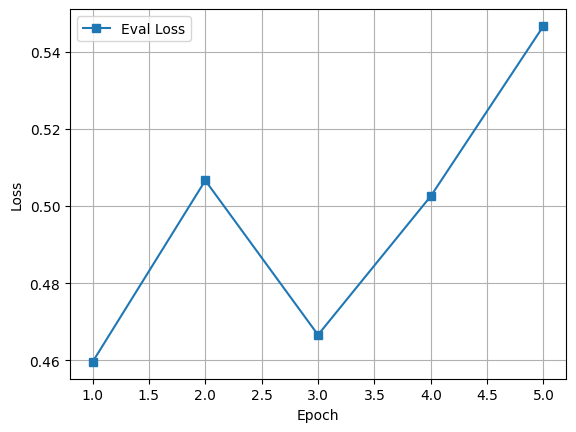

In [79]:
epochs = []
eval_loss = []
eval_accuracy = []
eval_f1 = []

train_epochs = []
# train_losses = [] 

for log in trainer.state.log_history:
    if "eval_loss" in log:
        epochs.append(log["epoch"])
        eval_loss.append(log["eval_loss"])
        eval_accuracy.append(log.get("eval_accuracy"))
        eval_f1.append(log.get("eval_f1"))
    if "loss" in log and "epoch" in log:
        train_epochs.append(log["epoch"])
        # train_losses.append(log["loss"]) ## vacia si not logging_strategy="steps" and logging_steps=logging_steps in Trainer 


# =========================
# 1) Accuracy y F1-score (validación)
# =========================
plt.figure()
plt.plot(epochs, eval_accuracy, marker="o", label="Accuracy")
plt.plot(epochs, eval_f1, marker="s", label="F1-score")
plt.xlabel("Epoch")
plt.ylabel("Score")
# plt.title(f"Desempeño del modelo")
plt.legend()
plt.grid(True)
plt.show()


# =========================
# 2) Loss vs Epoch
# =========================

plt.figure()
# plt.plot(train_epochs, train_losses, marker="o", label="Train Loss")
plt.plot(epochs, eval_loss, marker="s", label="Eval Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plt.title(f"Pérdida de validación")
plt.legend()
plt.grid(True)
plt.show()



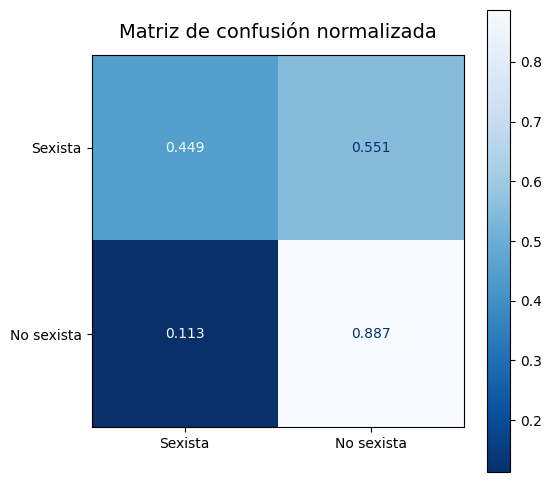

In [83]:
y_preds = np.argmax(preds_output.predictions, axis=1)
y_true = dataset_encoded["val"]["label"]

# labels = list(set(dataset_ES["train"]['label']))  
# label_map = {0: "Sexista", 1: "No sexista"}
# display_labels = [label_map[l] for l in sorted(labels)]
plot_confusion_matrix(y_preds, y_true, display_labels)

## Cabeza de clasificación 

In [105]:
model_name = "dccuchile/bert-base-spanish-wwm-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

c:\Users\ericl\anaconda3\envs\nlp\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [106]:
tokenized_dataset = dataset_ES.map(tokenize, batched=True)
tokenized_dataset

Map:   0%|          | 0/549 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3660
    })
    val: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 549
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1098
    })
})

In [107]:
tokenized_dataset.set_format('torch', columns=["input_ids", "attention_mask", "label"] )
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
train_dataloader = DataLoader(tokenized_dataset['train'], shuffle = True, batch_size = 32, collate_fn = data_collator)
eval_dataloader = DataLoader(tokenized_dataset['val'], shuffle = False, collate_fn = data_collator)

In [93]:
batch = next(iter(train_dataloader))
# print(f'X (word_ids) shape: {batch[0].shape}')   # Ejemplo: (batch_size, max_seq_length)
# print(f'y (labels) shape: {batch[2].shape}')  abs
print(f'Longitudes shape: {batch}')

Longitudes shape: {'input_ids': tensor([[    4, 19393,  6689,  ...,     1,     1,     1],
        [    4,   985,  8563,  ...,     1,     1,     1],
        [    4,  6018,  2209,  ...,     1,     1,     1],
        ...,
        [    4,   985,  8563,  ...,     1,     1,     1],
        [    4, 19898,  5425,  ...,     1,     1,     1],
        [    4,   985,  8563,  ...,     1,     1,     1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,
        0, 1, 1, 1, 1, 1, 1, 1])}


In [95]:
class CustomLayer(nn.Module): 
    def __init__(self, model_ckpt, num_labels ):
        """
        Args:
            checkpoint (str): The name of the pre-trained model or path to the model weights.
            num_labels (int): The number of output labels in the final classification layer.
        """
        super(CustomLayer, self).__init__()
        self.num_labels = num_labels
        
        self.model = model = AutoModel.from_pretrained( model_ckpt
                                                       , config = AutoConfig.from_pretrained(model_ckpt, 
                                                                                             output_attention = True, 
                                                                                             output_hidden_state = True ) )
        self.dropout = nn.Dropout(0.1)        
        self.classifier = nn.Linear(768, num_labels)

    
        
    def forward(self, input_ids = None, attention_mask=None, labels = None):

        outputs = self.model(input_ids = input_ids, attention_mask = attention_mask  )
        
        last_hidden_state = outputs[0]
        
        sequence_outputs = self.dropout(last_hidden_state)
        
        logits = self.classifier(sequence_outputs[:, 0, : ].view(-1, 768 ))
        
        loss = None
        loss = None
        if labels is not None:
            loss_func = nn.CrossEntropyLoss()
            loss = loss_func(logits.view(-1, self.num_labels), labels.view(-1))
            
            return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states, attentions=outputs.attentions)
        

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ckpt = "dccuchile/bert-base-spanish-wwm-uncased"
model_custom = CustomLayer(model_ckpt=model_ckpt, num_labels=2).to(device)

num_epoch = 3
num_training_steps = num_epoch * len(train_dataloader)


optimizer = AdamW(model_custom.parameters(), lr = 5e-5 )

lr_scheduler = get_scheduler('linear' 
                             , optimizer = optimizer
                             , num_warmup_steps = 0
                             , num_training_steps = num_training_steps)

criterion = nn.CrossEntropyLoss()

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [97]:
# import numpy as np 
def eval_model(model, dataloader, device, criterion):
    """
    Función para evaluar el modelo:
      - Calcula pérdida ponderada en cada batch
      - Devuelve (loss_promedio, accuracy, f1, preds, labels)
    """
    model.eval()
    losses = []
    preds_all = []
    labels_all = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            torch.cuda.empty_cache()
            # Pasar a device
            batch = {k: v.to(device) for k, v in batch.items()}
            labels = batch["labels"]

            # Computar pesos automáticos: w = [max/count0, max/count1]
            # count0 = (labels == 0).sum().float()
            # count1 = (labels == 1).sum().float()
            # max_c = torch.max(count0, count1)
            # w = torch.tensor([max_c / count0, max_c / count1], device=device)
            # criterion = nn.CrossEntropyLoss(weight=w)
            outputs = model(**batch)
            logits = outputs.logits
            loss = criterion(logits, labels)
            losses.append(loss.item())

            # Predicciones
            preds = torch.argmax(logits, dim=-1)
            preds_all.extend(preds.cpu().tolist())
            labels_all.extend(labels.cpu().tolist())

    # Métricas
    acc = np.mean(np.array(preds_all) == np.array(labels_all))
    f1  = f1_score(labels_all, preds_all, average="binary", pos_label=1)
    return np.mean(losses), acc, f1, preds_all, labels_all


In [99]:
train_loss_history = []
train_f1_history = []
val_loss_history = []
val_f1_history = []
best_val_f1 = 0

for epoch in range(num_epoch):
    model_custom.train()
    train_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epoch} - Training")
    for batch in train_bar:
        torch.cuda.empty_cache()
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch["labels"]

        # # Calcular pesos según distribución del batch
        # count0 = (labels == 0).sum().float()
        # count1 = (labels == 1).sum().float()
        # max_c = torch.max(count0, count1)
        # w = torch.tensor([max_c / count0, max_c / count1], device=device)

        # Definir criterio con pesos
        # criterion = nn.CrossEntropyLoss(weight=w)

        # Forward + loss + backward + step
        outputs = model_custom(**batch)
        logits = outputs.logits
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        train_bar.set_postfix(train_loss=loss.item())

    # Evaluar en train y validación
    tr_loss, tr_acc, tr_f1, _, _ = eval_model(model_custom, train_dataloader, device, criterion)
    va_loss, va_acc, va_f1, _, _ = eval_model(model_custom, eval_dataloader,  device, criterion)

    # Guardar históricos
    train_loss_history.append(tr_loss)
    train_f1_history.append(tr_f1)
    val_loss_history.append(va_loss)
    val_f1_history.append(va_f1)

    print(
        f"Epoch {epoch+1}/{num_epoch} | "
        f"train_loss: {tr_loss:.4f} | val_loss: {va_loss:.4f} | "
        f"train_f1:   {tr_f1:.4f} | val_f1:   {va_f1:.4f}"
    )

    # Guardar mejor modelo según F1 de validación
    if va_f1 > best_val_f1:
        best_val_f1 = va_f1
        torch.save(model_custom.state_dict(), "best_model_f1.pth")


Epoch 1/3 - Training:   0%|          | 0/115 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/549 [00:00<?, ?it/s]

Epoch 1/3 | train_loss: 0.1349 | val_loss: 0.4378 | train_f1:   0.9755 | val_f1:   0.8415


Epoch 2/3 - Training:   0%|          | 0/115 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/549 [00:00<?, ?it/s]

Epoch 2/3 | train_loss: 0.0441 | val_loss: 0.6306 | train_f1:   0.9923 | val_f1:   0.8498


Epoch 3/3 - Training:   0%|          | 0/115 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/549 [00:00<?, ?it/s]

Epoch 3/3 | train_loss: 0.0442 | val_loss: 0.6306 | train_f1:   0.9923 | val_f1:   0.8498


C:\Users\ericl\AppData\Local\Temp\ipykernel_21032\3525263288.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load("best_model_f1.pth", map_location=device)

Predicting:   0%|          | 0/549 [00:00<?, ?it/s]

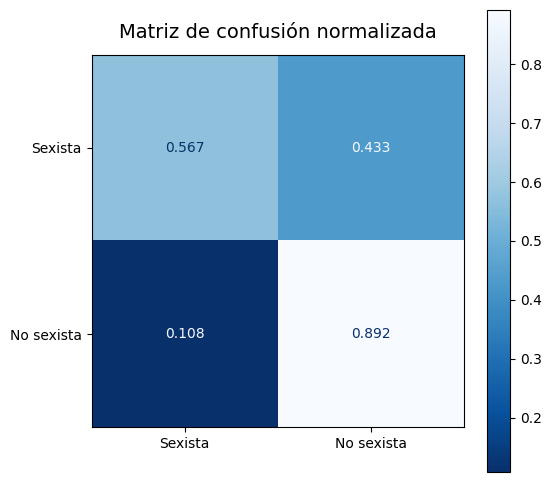

In [ ]:
# Cargar el mejor modelo entrenado y generar matriz de confusión usando la función existente

# model_ckpt = "dccuchile/bert-base-spanish-wwm-uncased"
# model_custom = CustomLayer(model_ckpt=model_ckpt, num_labels=2).to(device)
state = torch.load("best_model_f1.pth", map_location=device)
model_custom.load_state_dict(state)
model_custom.eval()

y_preds = []
y_true = []
with torch.no_grad():
    for batch in tqdm(eval_dataloader, desc="Predicting", leave=False):
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch['labels']
        outputs = model_custom(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        y_preds.extend(preds.cpu().tolist())
        y_true.extend(labels.cpu().tolist())

plot_confusion_matrix(y_preds, y_true, display_labels)